# An introduction to k-mers for genome comparison and analysis

k-mers provide sensitive and specific methods for comparing and analyzing genomes.

This notebook provides pure Python implementations of some of the basic k-mer comparison techniques implemented in sourmash, including hash-based subsampling techniques.

### Running this notebook.

You can run this notebook interactively via mybinder; click on this button:
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dib-lab/sourmash/latest?labpath=doc%2Fkmers-and-minhash.ipynb)

A rendered version of this notebook is available at [sourmash.readthedocs.io](https://sourmash.readthedocs.io) under "Tutorials and notebooks".

You can also get this notebook from the [doc/ subdirectory of the sourmash github repository](https://github.com/dib-lab/sourmash/tree/latest/doc). See [binder/environment.yaml](https://github.com/dib-lab/sourmash/blob/latest/binder/environment.yml) for installation dependencies.

### What is this?

This is a Jupyter Notebook using Python 3. If you are running this via [binder](https://mybinder.org), you can use Shift-ENTER to run cells, and double click on code cells to edit them.

Contact: C. Titus Brown, ctbrown@ucdavis.edu. Please [file issues on GitHub](https://github.com/dib-lab/sourmash/issues/) if you have any questions or comments!

## Calculating Jaccard similarity and containment

Given any two collections of k-mers, we can calculate similarity and containment using the union and intersection functionality in Python.

In [1]:
def jaccard_similarity(a, b):
    a = set(a)
    b = set(b)
    
    intersection = len(a.intersection(b))
    union = len(a.union(b))
    
    return intersection / union

In [2]:
def jaccard_containment(a, b):
    a = set(a)
    b = set(b)
    
    intersection = len(a.intersection(b))
    
    return intersection / len(a)

## Let's try these functions out on some simple examples!

In [3]:
a = ['ATGG', 'AACC']
b = ['ATGG', 'CACA']
c = ['ATGC', 'CACA']

In [4]:
jaccard_similarity(a, a)

1.0

In [5]:
jaccard_containment(a, a)

1.0

In [6]:
jaccard_similarity(b, a)

0.3333333333333333

In [7]:
jaccard_similarity(a, c)

0.0

In [8]:
jaccard_containment(b, a)

0.5

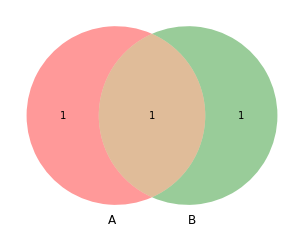

In [9]:
%matplotlib inline
from matplotlib_venn import venn2, venn3

venn2([set(a), set(b)])

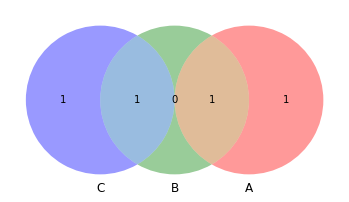

In [10]:
venn3([set(a), set(b), set(c)])

## Calculating k-mers from DNA sequences

To extract k-mers from DNA sequences, we walk over the sequence with a sliding window:

In [11]:
def build_kmers(sequence, ksize):
    kmers = []
    n_kmers = len(sequence) - ksize + 1
    
    for i in range(n_kmers):
        kmer = sequence[i:i + ksize]
        kmers.append(kmer)
        
    return kmers

In [12]:
build_kmers('ATGGACCAGATATAGGGAGAGCCAGGTAGGACA', 21)

['ATGGACCAGATATAGGGAGAG',
 'TGGACCAGATATAGGGAGAGC',
 'GGACCAGATATAGGGAGAGCC',
 'GACCAGATATAGGGAGAGCCA',
 'ACCAGATATAGGGAGAGCCAG',
 'CCAGATATAGGGAGAGCCAGG',
 'CAGATATAGGGAGAGCCAGGT',
 'AGATATAGGGAGAGCCAGGTA',
 'GATATAGGGAGAGCCAGGTAG',
 'ATATAGGGAGAGCCAGGTAGG',
 'TATAGGGAGAGCCAGGTAGGA',
 'ATAGGGAGAGCCAGGTAGGAC',
 'TAGGGAGAGCCAGGTAGGACA']

In the k-mers that are output, you can see how the sequence shifts to the right - look at the pattern in the middle.

So, now, you can compare two sequences!

In [13]:
seq1 = 'ATGGACCAGATATAGGGAGAGCCAGGTAGGACA'
seq2 = 'ATGGACCAGATATTGGGAGAGCCGGGTAGGACA'
# differences:       ^         ^

In [14]:
K = 10
kmers1 = build_kmers(seq1, K)
kmers2 = build_kmers(seq2, K)

print(K, jaccard_similarity(kmers1, kmers2))

10 0.09090909090909091


## Reading k-mers in from a file

In practice, we often need to work with 100s of thousands of k-mers, and this means loading them in from sequences in files.

There are three cut-down genome files in the `genomes/` directory that we will use below:

```
akkermansia.fa
shew_os185.fa
shew_os223.fa
```
The latter two are two strains of *Shewanella baltica*, and the first one is an unrelated genome *Akkermansia muciniphila*.

In [15]:
import screed # a library for reading in FASTA/FASTQ

def read_kmers_from_file(filename, ksize):
    all_kmers = []
    for record in screed.open(filename):
        sequence = record.sequence
        
        kmers = build_kmers(sequence, ksize)
        all_kmers += kmers

    return all_kmers

In [16]:
akker_kmers = read_kmers_from_file('genomes/akkermansia.fa', 31)

In [17]:
akker_kmers[:5]

['AAATCTTATAAAATAACCACATAACTTAAAA',
 'AATCTTATAAAATAACCACATAACTTAAAAA',
 'ATCTTATAAAATAACCACATAACTTAAAAAG',
 'TCTTATAAAATAACCACATAACTTAAAAAGA',
 'CTTATAAAATAACCACATAACTTAAAAAGAA']

In [18]:
print(len(akker_kmers))

499970


In [19]:
shew1_kmers = read_kmers_from_file('genomes/shew_os185.fa', 31)
shew2_kmers = read_kmers_from_file('genomes/shew_os223.fa', 31)

We can see the relationship between these three like so:

In [20]:
print('akker vs shew1', jaccard_similarity(akker_kmers, shew1_kmers))
print('akker vs shew2', jaccard_similarity(akker_kmers, shew2_kmers))
print('shew1 vs shew2', jaccard_similarity(shew1_kmers, shew2_kmers))

akker vs shew1 0.0
akker vs shew2 0.0
shew1 vs shew2 0.23675152210020398


In [21]:
print('akker vs shew1', jaccard_containment(akker_kmers, shew1_kmers))
print('akker vs shew2', jaccard_containment(akker_kmers, shew2_kmers))
print('shew1 vs shew2', jaccard_containment(shew1_kmers, shew2_kmers))

akker vs shew1 0.0
akker vs shew2 0.0
shew1 vs shew2 0.38397187523995907


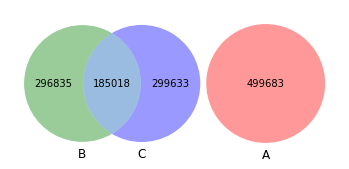

In [22]:
venn3([set(akker_kmers), set(shew1_kmers), set(shew2_kmers)])

## Let's hash!

## Choose a hash function!

We need to pick a hash function that takes DNA k-mers and converts them into numbers.

Both the [mash](https://mash.readthedocs.io/en/latest/) software for MinHash, and the [sourmash](https://sourmash.readthedocs.io) software for modulo and MinHash, use MurmurHash:

https://en.wikipedia.org/wiki/MurmurHash

this is implemented in the 'mmh3' library in Python.

The other thing we need to do here is take into account the fact that DNA is double stranded, and so

```
hash_kmer('ATGG')
```
should be equivalent to
```
hash_kmer('CCAT')
```
Following mash's lead, for every input k-mer we will choose a *canonical* k-mer that is the lesser of the k-mer and its reverse complement.

In [23]:
import mmh3

def hash_kmer(kmer):
    # calculate the reverse complement
    rc_kmer = screed.rc(kmer)
    
    # determine whether original k-mer or reverse complement is lesser
    if kmer < rc_kmer:
        canonical_kmer = kmer
    else:
        canonical_kmer = rc_kmer
        
    # calculate murmurhash using a hash seed of 42
    hash = mmh3.hash64(canonical_kmer, 42)[0]
    if hash < 0: hash += 2**64
        
    # done
    return hash

This is now a function that we can use to turn any DNA "word" into a number:

In [24]:
hash_kmer('ATGGC')

13663093258475204077

The same input word always returns the same number:

In [25]:
hash_kmer('ATGGC')

13663093258475204077

as does its reverse complement:

In [26]:
hash_kmer('GCCAT')

13663093258475204077

and nearby words return very different numbers:

In [27]:
hash_kmer('GCCAA')

1777382721305265773

## Note that hashing collections of k-mers doesn't change Jaccard calculations:

In [28]:
def hash_kmers(kmers):
    hashes = []
    for kmer in kmers:
        hashes.append(hash_kmer(kmer))
    return hashes

In [29]:
shew1_hashes = hash_kmers(shew1_kmers)
shew2_hashes = hash_kmers(shew2_kmers)

In [30]:
print(jaccard_similarity(shew1_kmers, shew2_kmers))

0.23675152210020398


In [31]:
print(jaccard_similarity(shew1_hashes, shew2_hashes))

0.2371520123045373


(ok, it changes it a little, because of the canonical k-mer calculation!)

## Implementing subsampling with modulo hashing

We are now ready to implement k-mer subsampling with modulo hash.

We need to pick a sampling rate, and know the maximum possible hash value.

For a sampling rate, let's start with 1000.

The MurmurHash function turns k-mers into numbers between 0 and `2**64 - 1` (the maximum 64-bit number).

Let's define these as variables:

In [32]:
scaled = 1000
MAX_HASH = 2**64

Now, choose the range of hash values that we'll keep.

In [33]:
keep_below = MAX_HASH / scaled
print(keep_below)

1.844674407370955e+16


and write a filter function:

In [34]:
def subsample_modulo(kmers):
    keep = []
    for kmer in kmers:
        if hash_kmer(kmer) < keep_below:
            keep.append(kmer)
        # otherwise, discard
        
    return keep

## Now let's apply this to our big collections of k-mers!

In [35]:
akker_sub = subsample_modulo(akker_kmers)
shew1_sub = subsample_modulo(shew1_kmers)
shew2_sub = subsample_modulo(shew2_kmers)

In [36]:
print(len(akker_kmers), len(akker_sub))
print(len(shew1_kmers), len(shew1_sub))
print(len(shew2_kmers), len(shew2_sub))

499970 502
499970 513
499970 503


So we go from ~500,000 k-mers to ~500 hashes! Do the Jaccard calculations change??

In [37]:
print('akker vs akker, total', jaccard_similarity(akker_kmers, akker_kmers))
print('akker vs akker, sub', jaccard_similarity(akker_sub, akker_sub))

akker vs akker, total 1.0
akker vs akker, sub 1.0


In [38]:
print('akker vs shew1, total', jaccard_similarity(akker_kmers, shew1_kmers))
print('akker vs shew1, sub', jaccard_similarity(akker_sub, shew1_sub))

akker vs shew1, total 0.0
akker vs shew1, sub 0.0


In [39]:
print('shew1 vs shew2, total', jaccard_similarity(shew1_kmers, shew2_kmers))
print('shew1 vs shew2, sub', jaccard_similarity(shew1_sub, shew2_sub))

shew1 vs shew2, total 0.23675152210020398
shew1 vs shew2, sub 0.2281795511221945


And you can see that the numbers are different, but not very much - the Jaccard similarity is being *estimated*, so it is not exact but it is close.

## Let's visualize --

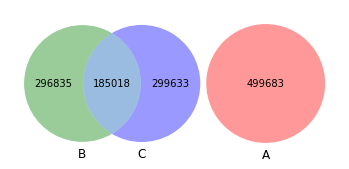

In [40]:
venn3([set(akker_kmers), set(shew1_kmers), set(shew2_kmers)])

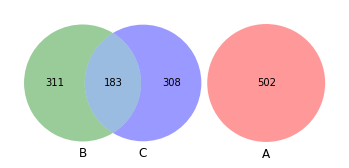

In [41]:
venn3([set(akker_sub), set(shew1_sub), set(shew2_sub)])

## Other pointers

[Sourmash: a practical guide](https://sourmash.readthedocs.io/en/latest/using-sourmash-a-guide.html)

[Classifying signatures taxonomically](https://sourmash.readthedocs.io/en/latest/classifying-signatures.html)

[Pre-built search databases](https://sourmash.readthedocs.io/en/latest/databases.html)

## A full list of notebooks

[An introduction to k-mers for genome comparison and analysis](kmers-and-minhash.ipynb)

[Some sourmash command line examples!](sourmash-examples.ipynb)

[Working with private collections of signatures.](sourmash-collections.ipynb)

[Using the LCA_Database API.](using-LCA-database-API.ipynb)
